# seq2seq with attention for E2E dataset
目的：E2E dtaset を対象としたレビュー文生成

下記のコードの元ネタ：  
https://torch.classcat.com/2021/04/23/pytorch-1-8-tutorials-intermediate-seq2seq-translation/

上記サイトは下記チュートリアルの翻訳：  
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

E2E dataset は，下記のサイトに置かれている e2e_refined_dataset_v1_0_0.zip を使用した。

https://github.com/KSKTYM/E2E-refined-dataset/tree/main/release

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
# 単語の one-hot encoding へ向けた準備
SOS_token = 0
EOS_token = 1

class MR:
    # def __init__(self, name):
    def __init__(self):
        #self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
        # (メモ) MR には SOS / EOS は不要
        # self.index2word = {0: "SOS", 1: "EOS"}
        # self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# フランス語／英語それぞれにコードブックが必要なため Lang クラスを準備する
class Lang:
    # def __init__(self, name):
    def __init__(self):
        # self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# (注) 以下は単語数を減らすための工夫であり，本質的でない。

# Unicode 文字を ASCII に変え、総てを小文字にして、そして殆どの句読点をトリム
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    # s = unicodeToAscii(s.lower().strip())
    s = unicodeToAscii(s.strip()) # 小文字化しない for E2E dataset
    s = re.sub(r"([,.!?])", r" \1", s) # カンマ，ピリオド，!, ? の前にスペースを入れる
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # カンマを消さないよう，この処理は不要
    return s

In [5]:
import json

def load_e2e_data(path):
    mrs = list()
    texts = list()
    
    with open(path, "r") as f:
        js = json.load(f)

        for item in js:
            order = item['mr']['order'] # mr に含まれる属性の順番
            value = item['mr']['value'] # 各属性に対応する値

            # order から順番に応じて属性(attribute / slot) を並べる
            sorted_order = sorted(order.items(), key=lambda x:x[1])
            new_order = [k for k, v in sorted_order if v != 0]

            # seq2seq へ与える形式で mr を構成する
            mr = []
            for attr in new_order:
                mr.append('inform')
                mr.append(attr)
                mr.append(value[attr])

            # seq2seq へ与える形式で text を構成する
            mrs.append(mr)
            texts.append(item['txt'])
            
    return mrs, texts

train_file = "e2e_refined_dataset/e2e_train.json"
mrs, texts = load_e2e_data(train_file)

In [6]:
# データ読み込みの準備
# def readLangs(lang1, lang2, reverse=False):
def readLangs():
    print("Reading lines...")

    # Read the file and split into lines
    train_file = "e2e_refined_dataset/e2e_train.json"
    mrs, texts = load_e2e_data(train_file)

    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #    read().strip().split('\n')

    # Split every line into pairs and normalize
    # pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = []
    for mr, text in zip(mrs, texts):
        splitted_text = normalizeString(text)
        # print(splitted_text)
        pairs.append([mr, splitted_text])

    # Reverse pairs, make Lang instances
    '''
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    '''
    input_mr = MR()
    output_text = Lang()

    return input_mr, output_text, pairs

input_mr, output_text, pairs = readLangs()
print(pairs[:3])

Reading lines...
[[['inform', 'name', 'THE VAULTS', 'inform', 'eatType', 'pub', 'inform', 'near', 'CAFÉ ADRIATIC', 'inform', 'customer rating', '5 out of 5', 'inform', 'priceRange', 'more than £30'], 'THE VAULTS pub near CAFE ADRIATIC has a 5 star rating . Prices start at £30 .'], [['inform', 'near', 'CAFÉ BRAZIL', 'inform', 'name', 'THE CAMBRIDGE BLUE', 'inform', 'eatType', 'pub', 'inform', 'priceRange', '£20-25'], 'Close to CAFE BRAZIL , THE CAMBRIDGE BLUE pub serves delicious tuscan beef for the cheap price of £20 . Delicious pub food .'], [['inform', 'name', 'THE EAGLE', 'inform', 'customer rating', 'low', 'inform', 'eatType', 'coffee shop', 'inform', 'near', 'BURGER KING', 'inform', 'area', 'riverside', 'inform', 'familyFriendly', 'yes', 'inform', 'priceRange', 'less than £20', 'inform', 'food', 'Japanese'], 'THE EAGLE is a low rated coffee shop near BURGER KING and the riverside that is family friendly and is less than £20 for Japanese food .']]


In [7]:
# MAX_LENGTH = 10
MR_MAX_LENGTH = 25 # 10
TEXT_MAX_LENGTH = 100

In [8]:
# (=====注意=====) E2E では使わない !!

# (注) 単語数チェックは必要だが，トリミングは本質的でない。

# データセットを比較的短くて単純なセンテンスだけにトリム
# MAX_LENGTH = 100 # 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
# def prepareData(lang1, lang2, reverse=False):
def prepareData():
    # データ読み込み
    # input_lang / output_lang には「単語とIDのコードブック」が格納される
    # pairs には「フランス語文と英語文のペア」が格納される
    # input_mr, output_text, pairs = readLangs(lang1, lang2, reverse)
    input_mr, output_text, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    
    # 単語数が MAX_LENGTH を超える文の除去 & eng_prefixes で定義された文型のみに絞り込む
    #pairs = filterPairs(pairs)
    #print("Trimmed to %s sentence pairs" % len(pairs))

    # 全データについて，単語と ID を紐付ける
    print("Counting words...")
    for pair in pairs:
        # input_lang.addSentence(pair[0])
        # output_lang.addSentence(pair[1])
        input_mr.addSentence(pair[0])
        output_text.addSentence(pair[1])
        
    # (参考) 単語数のカウント
    print("Counted words:")
    # print(input_lang.name, input_lang.n_words)
    # print(output_lang.name, output_lang.n_words)
    # return input_lang, output_lang, pairs
    print("MR:", input_mr.n_words)
    print("Text:", output_text.n_words)
    return input_mr, output_text, pairs


# input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
input_mr, output_text, pairs = prepareData()
print(random.choice(pairs))

Reading lines...
Read 40560 sentence pairs
Counting words...
Counted words:
MR: 95
Text: 3083
[['inform', 'area', 'riverside', 'inform', 'eatType', 'pub', 'inform', 'name', 'THE WATERMAN', 'inform', 'food', 'Indian', 'inform', 'customer rating', '1 out of 5'], 'On the riverside is a pub , THE WATERMAN , which serves Indian food . It is rated one out of five stars by customers .']


In [10]:
# (参考)
print(input_mr.word2index['eatType'])
print(output_text.word2index['prices'])

3
131


---
## seq2seq モデル

エンコーダが生成する(単一の)ベクトル = 理想的には、入力センテンスの「意味」

In [11]:
# エンコーダ
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # (メモ) nn.Embedding(語彙サイズ, 埋め込む次元)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # 単語ひとつが入ってくることを前提に view()
        # output = embedded # (メモ) 余分な記述ゆえ，書き直し
        # output, hidden = self.gru(output, hidden) # (メモ) 余分な記述ゆえ，書き直し
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    # エンコーダへ渡す初期隠れ状態 (zero ベクトル)
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
# デコーダ
# (注) 使用しない
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # (メモ) nn.Embedding(語彙サイズ, 埋め込む次元)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # 単語ひとつが入ってくることを前提に view()
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    # デコーダへ渡す初期隠れ状態 (zero ベクトル) ・・・(メモ) seq2seq モデルでは不要では？
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
# attention デコーダ
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, mr_max_length=MR_MAX_LENGTH, text_max_length=TEXT_MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        # self.max_length = max_length
        self.mr_max_length = mr_max_length
        self.text_max_length = text_max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn = nn.Linear(self.hidden_size * 2, self.mr_max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # attention weight の算出
        # print("input:", input.size()) # torch.Size([1, 1]
        # print("embedded:", embedded.size()) # torch.Size([1, 1, 256]
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        #print("attn_weights:", attn_weights.size()) # torch.Size([1, 10]) ・・・入力文の単語数に依存
        #print("encoder_outputs:", encoder_outputs.size()) # torch.Size([10, 256])
        #print("encoder_outputs.unsqueeze(0):", encoder_outputs.unsqueeze(0).size()) # torch.Size([1, 10, 256])
        
        # エンコーダの出力と attention weight との内積
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # アテンションとデコーダへの入力(embedding)を Linear 層へ投げ込む
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 学習

In [14]:
# MR の属性/値ペア ＆ テキストを数値化 ＆ テンソル化する関数群
'''
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)
'''
def indexesFromMR(input_mr, sentence):
    return [input_mr.word2index[word] for word in sentence]

def indexesFromSentence(output_text, sentence):
    return [output_text.word2index[word] for word in sentence.split(' ')]

def tensorFromMR(input_mr, sentence):
    indexes = indexesFromMR(input_mr, sentence)
    # indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence(output_text, sentence):
    indexes = indexesFromSentence(output_text, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromMR(input_mr, pair[0])
    target_tensor = tensorFromSentence(output_text, pair[1])
    return (input_tensor, target_tensor)

In [15]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, mr_max_length=MR_MAX_LENGTH, text_max_length=TEXT_MAX_LENGTH):
    # エンコーダの初期隠れ層を定義 (zero ベクトル)
    encoder_hidden = encoder.initHidden()

    # optimizer の初期化
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # 入力，出力それぞれに含まれる単語数
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # エンコードの全ての隠れ層の値を保存するための変数
    # 長さが MAX_LENGTH である点に注意
    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    encoder_outputs = torch.zeros(mr_max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # エンコード : 埋め込み + GRU
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # 隠れ層の値を溜める
        encoder_outputs[ei] = encoder_output[0, 0]

    # デコーダに与える最初のトークン : SOS_token
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # デコーダに与える隠れ層の初期値は，エンコーダの最終隠れ層の値
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # デコード
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # デコードの結果と所望の出力（この例では，期待する英単語）から損失を求める
            loss += criterion(decoder_output, target_tensor[di])
            # デコーダに与える次のトークンを準備
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # 文ペアを１つ，エンコード／デコードし終えたならば逆伝搬
    loss.backward()

    # エンコーダー／デコーダそれぞれの optimizer を更新
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
# helper functions
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # optimizer の定義
    '''
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    '''
    encoder_optimizer = optim.Adam(encoder.parameters())
    decoder_optimizer = optim.Adam(decoder.parameters())
    
    # 学習対象とするフランス語文／英語文のペアをランダムな順序，かつ重複ありにて生成
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    # 損失関数の定義
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # 学習対象とするフランス語文／英語文のペアをひとつ選ぶ
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # 学習
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # ログ出力
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # 損失の可視化
    showPlot(plot_losses)

In [18]:
# 損失の可視化
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [19]:
# 学習
hidden_size = 256 # GRU の隠れ層のサイズ

# エンコーダ／デコーダの定義
encoder1 = EncoderRNN(input_mr.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_text.n_words, dropout_p=0.1).to(device)

# 学習 (重複ありにて 75000ペアを学習させる)
# (2022.12.05 メモ) 5,000ペアを学習するのに 2m 15s を要する。
# (2022.12.05 メモ) 学習データには 40560件の (mr, text) ペアが存在するから
# 75000ペアの学習では不十分だろう。
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 100000, print_every=5000)

2m 27s (- 46m 50s) (5000 5%) 2.8570
4m 56s (- 44m 29s) (10000 10%) 2.4687
7m 25s (- 42m 3s) (15000 15%) 2.3958
9m 53s (- 39m 35s) (20000 20%) 2.3752
12m 19s (- 36m 59s) (25000 25%) 2.3394
14m 46s (- 34m 28s) (30000 30%) 2.3182
17m 13s (- 31m 59s) (35000 35%) 2.3524
19m 39s (- 29m 29s) (40000 40%) 2.3380
22m 5s (- 27m 0s) (45000 45%) 2.3560
24m 32s (- 24m 32s) (50000 50%) 2.3414
26m 59s (- 22m 5s) (55000 55%) 2.3153
29m 25s (- 19m 37s) (60000 60%) 2.3184
31m 52s (- 17m 9s) (65000 65%) 2.3606
34m 19s (- 14m 42s) (70000 70%) 2.3410
36m 46s (- 12m 15s) (75000 75%) 2.3341
39m 12s (- 9m 48s) (80000 80%) 2.3209
41m 38s (- 7m 20s) (85000 85%) 2.3255
44m 5s (- 4m 53s) (90000 90%) 2.3636
46m 31s (- 2m 26s) (95000 95%) 2.3323
48m 58s (- 0m 0s) (100000 100%) 2.3197


/tmp/ipykernel_42810/1383405497.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## 評価

In [20]:
# 評価
def evaluate(encoder, decoder, sentence, mr_max_length=MR_MAX_LENGTH, text_max_length=TEXT_MAX_LENGTH):
    with torch.no_grad():
        # input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = tensorFromMR(input_mr, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        encoder_outputs = torch.zeros(mr_max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] # (メモ) 元が zero vector だからよいけど，代入じゃ駄目なの？

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)
        decoder_attentions = torch.zeros(text_max_length, mr_max_length) #### (12/5) 自信なし！

        for di in range(text_max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                # decoded_words.append(output_lang.index2word[topi.item()])
                decoded_words.append(output_text.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
evaluateRandomly(encoder1, attn_decoder1)

> ['inform', 'name', 'THE WRESTLERS', 'inform', 'food', 'Italian', 'inform', 'eatType', 'restaurant', 'inform', 'priceRange', 'moderate', 'inform', 'familyFriendly', 'yes']
= THE WRESTLERS Italian restaurant is medium priced . It is family friendly and medium priced .
< THE WRESTLERS is an Italian restaurant that is kid friendly and is moderately priced . 

> ['inform', 'eatType', 'restaurant', 'inform', 'area', 'riverside', 'inform', 'name', 'THE TWENTY TWO', 'inform', 'familyFriendly', 'yes', 'inform', 'near', 'THE RICE BOAT', 'inform', 'priceRange', 'cheap']
= There a restaurant in the riverside area called THE TWENTY TWO its family friendly and right by THE RICE BOAT . The prices are very low .
< The restaurant THE TWENTY TWO is located in the riverside area , THE RICE BOAT is family friendly , is cheap , and is 

> ['inform', 'name', 'ALIMENTUM', 'inform', 'near', 'YIPPEE NOODLE BAR', 'inform', 'area', 'city centre', 'inform', 'food', 'fast food', 'inform', 'eatType', 'restaurant'

## attention の可視化

['THE', 'WATERMAN', 'pub', 'a', 'pub', 'in', 'the', 'riverside', 'area', 'of', '3', 'out', 'of', 'of', '5', '.', '']


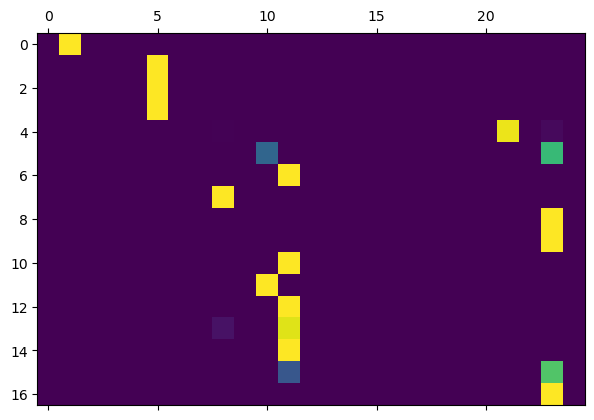

In [30]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1,
    ['inform', 'name', 'THE WATERMAN', 'inform', 'eatType', 'pub', 'inform', 'area', 'riverside', 'inform', 'customer rating', '3 out of 5']
)
print(output_words)
plt.matshow(attentions.numpy())

input = ['inform', 'name', 'THE EAGLE', 'inform', 'food', 'Japanese', 'inform', 'customer rating', 'low']
output = THE EAGLE serves Japanese food and has a low customer rating . 


/tmp/ipykernel_7102/2570250603.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence +
/tmp/ipykernel_7102/2570250603.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


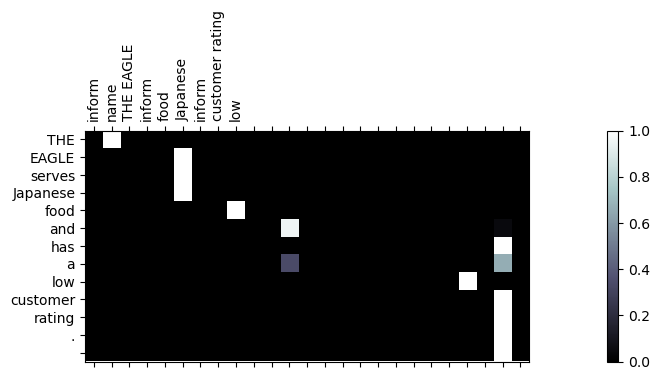

input = ['inform', 'name', 'ZIZZI', 'inform', 'food', 'French', 'inform', 'eatType', 'pub', 'inform', 'customer rating', 'low', 'inform', 'familyFriendly', 'yes']
output = ZIZZI is a French pub a a a low customer family friendly . 


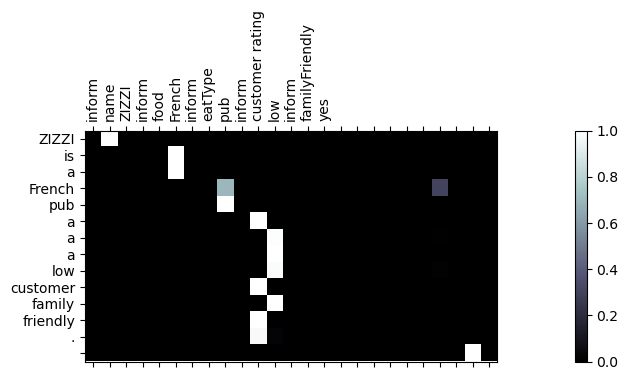

In [32]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    # fig = plt.figure()
    fig = plt.figure(figsize=(20,3))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    '''
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [''], rotation=90)
    '''
    ax.set_xticklabels([''] + input_sentence +
                       [''], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

'''
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")
'''

mr1 = ['inform', 'name', 'THE EAGLE', 'inform', 'food', 'Japanese', 'inform', 'customer rating', 'low']
evaluateAndShowAttention(mr1)

mr2 = ['inform', 'name', 'ZIZZI', 'inform', 'food', 'French', 'inform', 'eatType', 'pub', 'inform', 'customer rating', 'low', 'inform', 'familyFriendly', 'yes']
evaluateAndShowAttention(mr2)